In [1]:
import json

with open("probe_dataset/probe_labels.json", "r") as file:
    data = json.load(file)
import pandas as pd
anno = pd.DataFrame(data['annotations'])
anno.set_index('image_id', inplace=True)
image = pd.DataFrame(data['images'])
image.set_index('id', inplace=True)
info = pd.merge(image, anno,left_on='id',right_on='image_id')
# 将 'ID' 列设置为索引
info_indexed = info.set_index('file_name')

In [ ]:
info['height'].nunique()
info['width'].nunique()

In [ ]:
import matplotlib.pyplot as plt
import cv2

# 假设 `info` DataFrame 中的文件名列名是 'file_name'
file_name = info.iloc[3]['file_name']

# 加载图片
image = cv2.imread('probe_dataset/probe_images/'+file_name, cv2.IMREAD_GRAYSCALE)

# 绘制图片
plt.figure(figsize=(8, 8))
plt.imshow(image)
equalized_image = cv2.equalizeHist(image)
image = cv2.fastNlMeansDenoising(equalized_image, None, 20, 7, 21)
edges = cv2.Canny(image.astype('uint8'), threshold1=80, threshold2=150)
plt.figure(figsize=(8, 8))
plt.imshow(edges)

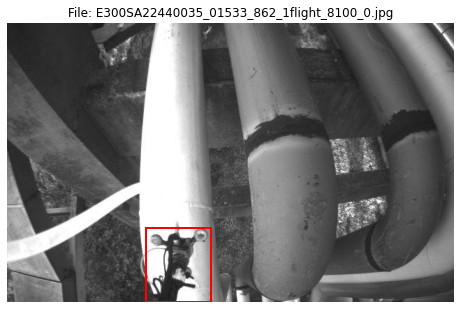

In [3]:
import matplotlib.pyplot as plt
import cv2

# 假设 `info` DataFrame 中的文件名列名是 'file_name'
file_name = info.iloc[6]['file_name']

# 加载图片
image = cv2.imread('probe_dataset/probe_images/'+file_name)

# 假设对应的边界框数据存储在列 'bbox' 中
bbox = info.iloc[6]['bbox']  # 边界框格式为 [x_min, y_min, x_max, y_max]

# 绘制图片
plt.figure(figsize=(8, 8))
plt.imshow(image)

# 添加矩形框
x, y, width, height = bbox

plt.gca().add_patch(plt.Rectangle((x, y), width, height,
                                          edgecolor='red', facecolor='none', linewidth=2))

# 添加标题或其他注释（可选）
plt.title(f"File: {file_name}")
plt.axis('off')
plt.show()


In [ ]:
# 假设目标列的列名为 'bbox'
all_values = info['bbox'].explode()  # 将列表元素展开为单独的行
max_value = all_values.max()       # 找到最大值

print(f"合并后的最大值是: {max_value}")


In [ ]:
# 确保新列存在
info['bbox_normalized'] = info.apply(
    lambda row: [
        (row['bbox'][0] + row['bbox'][2]/2) / row['width'],
        (row['bbox'][1] + row['bbox'][3]/2) / row['height'],
        row['bbox'][2] / row['width'],
        row['bbox'][3] / row['height']
    ],
    axis=1
)

In [ ]:
import matplotlib.pyplot as plt
import cv2

# 假设 `info` DataFrame 中的文件名列名是 'file_name'
file_name = info.iloc[6]['file_name']

# 加载图片
image = cv2.imread('probe_dataset/probe_images/'+file_name)

# 假设对应的边界框数据存储在列 'bbox' 中
bbox_normalized = info.iloc[6]['bbox_normalized']  # 边界框格式为 [x_min, y_min, x_max, y_max]

# 绘制图片
plt.figure(figsize=(8, 8))
plt.imshow(image)

# 添加矩形框
img_width = 640
img_height = 400
x_center, y_center, width, height = bbox_normalized
x_min = int((x_center - width / 2) * img_width)
y_min = int((y_center - height / 2) * img_height)
x_max = int((x_center + width / 2) * img_width)
y_max = int((y_center + height / 2) * img_height)

# 绘制图像和 bounding box
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.gca().add_patch(plt.Rectangle((x_min, y_min), width * img_width, height * img_height,
                                    edgecolor='red', facecolor='none', linewidth=2))


# 添加标题或其他注释（可选）
plt.title(f"File: {file_name}")
plt.axis('off')
plt.show()


In [ ]:
import os
import random
from shutil import copy2

dataset_path = "probe_dataset/probe_images"
output_path = "yolov11/images"
train_ratio = 0.8  # 训练集比例

# 创建目标文件夹
os.makedirs(f"{output_path}/train", exist_ok=True)
os.makedirs(f"{output_path}/val", exist_ok=True)

# 获取所有文件
files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg')]
random.shuffle(files)

# 按比例划分
train_count = int(len(files) * train_ratio)
train_files = files[:train_count]
val_files = files[train_count:]

# 复制文件
for f in train_files:
    copy2(os.path.join(dataset_path, f), os.path.join(output_path, "train"))

for f in val_files:
    copy2(os.path.join(dataset_path, f), os.path.join(output_path, "val"))

print("数据集已按比例划分完成！")


In [ ]:
import os
output_path = "yolov11/images"
# 指定文件夹路径
folder_path = output_path + '/train'  # 原始文件路径
txt_path = 'yolov11/labels/train/'    # 标签文件路径

# 确保目标路径存在
os.makedirs(txt_path, exist_ok=True)

# 获取文件夹中所有文件名
file_names = os.listdir(folder_path)

# 遍历文件并生成对应的 .txt 文件
for f in file_names:
    try:
        # 从索引中提取对应的 bbox 信息
        bbox_norm = info_indexed.loc[f, 'bbox_normalized']
        bbox_norm_str = " ".join(map(str, bbox_norm)) 
        
        # 构造 txt 文件的路径
        txt_file_path = os.path.join(txt_path, f.split('.')[0] + '.txt')  # 去掉扩展名，加上 .txt

        # 写入文件
        with open(txt_file_path, "w") as file:
            file.write(f"0 {bbox_norm_str}")

        print(f"文件已生成：{txt_file_path}")

    except KeyError:
        print(f"文件 {f} 在 info_indexed 中未找到对应的 bbox_normalized 信息！")


In [ ]:
import os

# 指定文件夹路径
folder_path = output_path + '/val'  # 原始文件路径
txt_path = 'yolov11/labels/val/'    # 标签文件路径

# 确保目标路径存在
os.makedirs(txt_path, exist_ok=True)

# 获取文件夹中所有文件名
file_names = os.listdir(folder_path)

# 遍历文件并生成对应的 .txt 文件
for f in file_names:
    try:
        # 从索引中提取对应的 bbox 信息
        bbox_norm = info_indexed.loc[f, 'bbox_normalized']
        bbox_norm_str = " ".join(map(str, bbox_norm)) 

        # 构造 txt 文件的路径
        txt_file_path = os.path.join(txt_path, f.split('.')[0] + '.txt')  # 去掉扩展名，加上 .txt

        # 写入文件
        with open(txt_file_path, "w") as file:
            file.write(f"0 {bbox_norm_str}")

        print(f"文件已生成：{txt_file_path}")

    except KeyError:
        print(f"文件 {f} 在 info_indexed 中未找到对应的 bbox_normalized 信息！")


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# 设置图像路径和标签路径
image_folder = 'yolov11/images/train'  # 图像文件路径
label_folder = 'yolov11/labels/train'    # 标签文件路径

# 获取文件夹中所有文件
file_names = os.listdir(image_folder)

# 随机抽取 50 个文件
sample_files = random.sample(file_names, 10)

# 遍历随机抽取的文件
for f in sample_files:
    try:
        # 读取图像路径
        image_path = os.path.join(image_folder, f)
        img = Image.open(image_path)

        # 获取标签路径
        label_file_path = os.path.join(label_folder, f.split('.')[0] + '.txt')

        # 读取 bbox_normalized 信息
        with open(label_file_path, 'r') as label_file:
            label_data = label_file.read().strip().split()
        
        # 提取类别和 bbox 信息
        class_id = int(label_data[0])  # 类别 ID
        bbox_normalized = list(map(float, label_data[1:]))

        # 图像宽高
        img_width, img_height = img.size
        print(img.size)

        # 转换 bbox 到像素坐标
        x_center, y_center, width, height = bbox_normalized
        x_min = int((x_center - width / 2) * img_width)
        y_min = int((y_center - height / 2) * img_height)
        x_max = int((x_center + width / 2) * img_width)
        y_max = int((y_center + height / 2) * img_height)

        # 绘制图像和 bounding box
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.title(f"File: {f}, Class ID: {class_id}")
        plt.show()

    except FileNotFoundError:
        print(f"标签文件未找到: {f.split('.')[0] + '.txt'}")
    except Exception as e:
        print(f"处理文件 {f} 时出错: {e}")


In [ ]:
from ultralytics import YOLO
import os
import random
# 文件夹路径
folder_path = "yolov11/images/val/"

# 获取所有图片文件名
all_images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]

# 随机选择 50 张图片
random_images = random.sample(all_images, 10)
# Load a model
model = YOLO("model_1228/train/weights/best.pt")  # pretrained YOLO11n model

# Run batched inference on a list of images
results = model(random_images)# return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk

In [14]:
import sys
print(sys.path)
from utils import draw_detections,compute_iou,xywh2xyxy
from ultralytics import YOLO
import os
import random
import numpy as np
import cv2
# # Load the YOLO11 model
# model = YOLO("model_1228/train/weights/best.pt")

# # Export the model to ONNX format
# model.export(format="onnx")  # creates 'yolo11n.onnx'

# Load the exported ONNX model
onnx_model = YOLO("model_1228/train/weights/best.onnx")
folder_path = "yolov11/images/val/"

# 获取所有图片文件名
all_images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
# # Run inference
# results = onnx_model("https://ultralytics.com/images/bus.jpg")
# Load a model

# Run batched inference on a list of images
# results = onnx_model(random_images)# return a list of Results objects

# Process results list
for i in all_images:
    result = onnx_model(i)[0]
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb
    cv_img = draw_detections(result.orig_img, boxes, boxes.conf)  # Oriented boxes object for OBB outputs7
    gt = info_indexed.loc[i.split('/')[-1]]['bbox']
    box_true = xywh2xyxy(gt)
    x1, y1, x2, y2 = map(int, box_true[:4])
    cv2.rectangle(cv_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    if boxes.xyxy.size(0) == 0:  # Check if the tensor is empty
        # Add text to the image
        cv2.putText(
            cv_img,  # Image to draw on
            "No detections found",  # Text to display
            (50, 50),  # Bottom-left corner of the text
            cv2.FONT_HERSHEY_SIMPLEX,  # Font type
            1,  # Font scale
            (0, 0, 255),  # Text color in BGR (Red here)
            2,  # Thickness of the text
        )

        with open('iou.csv', 'a') as f:
            # Write the data
            filename = i.split('/')[-1]
            f.write(f"{filename},0\n")
    else:
        with open('iou.csv', 'a') as f:
            # Write the data
            filename = i.split('/')[-1]
            iou = compute_iou(box_true, boxes.xyxy)[0]
            f.write(f"{filename},{iou.item()}\n")
    # cv2.imshow('output',result.orig_img)
    cv2.namedWindow("output", cv2.WINDOW_NORMAL)
    cv2.imshow('output', cv_img)
    cv2.waitKey(0)
    # result.show()  # display to screen
    # result.save(filename="result.jpg")  # save to disk


['d:\\24fall\\Internship\\Flyability', 'e:\\anaconda3\\python39.zip', 'e:\\anaconda3\\DLLs', 'e:\\anaconda3\\lib', 'e:\\anaconda3', '', 'C:\\Users\\Mao\\AppData\\Roaming\\Python\\Python39\\site-packages', 'e:\\anaconda3\\lib\\site-packages', 'e:\\anaconda3\\lib\\site-packages\\win32', 'e:\\anaconda3\\lib\\site-packages\\win32\\lib', 'e:\\anaconda3\\lib\\site-packages\\Pythonwin']
WARNING  Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading model_1228\train\weights\best.onnx for ONNX Runtime inference...
Preferring ONNX Runtime AzureExecutionProvider

image 1/1 d:\24fall\Internship\Flyability\yolov11\images\val\E300PREMP00002_00725_216_1flight_2700_2.jpg: 640x640 1 probe, 79.0ms
Speed: 3.0ms preprocess, 79.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 d:\24fall\Internship\Flyability\yolov11\images\val\E300PREMP00002_00725_216_1flight_9

In [23]:
pd.read_csv('iou.csv', names=['name', 'iou'])['iou'].mean()

0.9215585695159051

In [23]:
import cv2
import numpy as np

# Construct the image path
image_path = 'probe_dataset/probe_images/' + i.split('/')[-1]

# Read the image
img = cv2.imread(image_path)

# Extract bounding box information (x, y, width, height) from `info_indexed`
x, y, width, height = info_indexed.loc[i.split('/')[-1]]['bbox']

# Convert bbox format from (x, y, width, height) to (x_min, y_min, x_max, y_max)
x_min, y_min = int(x), int(y)
x_max, y_max = int(x + width), int(y + height)

# Draw the rectangle on the image (red rectangle)
cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)  # Red color in BGR, thickness=2

# Optionally, add a title or annotation (OpenCV doesn't have titles like Matplotlib)
file_name = i.split('/')[-1]
cv2.putText(img, f"File: {file_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)  # Green text

# Display the image
cv2.namedWindow('Image with Rectangle', cv2.WINDOW_NORMAL)  # Allows resizing
cv2.imshow('Image with Rectangle', img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import os
import random
import onnxruntime
from PIL import Image
import numpy as np
import cv2
import torchvision.transforms as transforms
def preprocess_image(image_path, input_size=(640, 640)):
    # Load the image
    image = Image.open(image_path).convert("RGB")
    # Transform the image (resize, normalize, convert to tensor)
    transform = transforms.Compose([
        transforms.Resize(input_size),  # Resize to match the model's input size
        transforms.ToTensor(),         # Convert to tensor
    ])
    # Apply transformations
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    # Convert to numpy array and ensure float32 type
    return input_tensor.numpy().astype(np.float32), np.array(image)  # Return original image for visualization

# Create an ONNX inference session
providers = ['CPUExecutionProvider']
onnx_model_run = onnxruntime.InferenceSession("model_1228/train/weights/best.onnx", providers=providers)
onnx_model = YOLO("model_1228/train/weights/best.onnx")
# Perform inference and visualize
for image_path in random_images:
    # Preprocess the image
    input_tensor, original_image = preprocess_image(image_path)
    h, w, _ = original_image.shape  # Original image dimensions
    # Inference: Make sure the input name matches your ONNX model's expected input
    input_name = onnx_model_run.get_inputs()[0].name
    outputs = onnx_model_run.run(None, {input_name: input_tensor})
    results = onnx_model(i)[0]
    # Example output parsing (assume boxes and scores are in outputs[0])
    # Adjust parsing logic based on your specific ONNX model's output structure
    boxes = outputs[0][:, :4].transpose(1,0,2)  # Bounding boxes (x1, y1, x2, y2)
    scores = outputs[0][:, 4] # Confidence scores

    threshold = 0.8
    valid_indices = scores > threshold
    filtered_boxes = boxes[:, valid_indices]
    filtered_scores = scores[valid_indices]
    if filtered_boxes.size > 0:
        # for i in filtered_boxes
        for i in range(filtered_boxes.shape[1]):
            filtered_box = filtered_boxes[:,i]
            x_center, y_center, width, height = filtered_box
        
            # Convert to x1, y1, x2, y2
            x1 = int((x_center - width / 2) )
            y1 = int((y_center - height / 2) )
            x2 = int((x_center + width / 2) )
            y2 = int((y_center + height / 2) )
            
            cv2.rectangle(original_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box
            cv2.putText(original_image, f"{filtered_scores[i]:.2f}", 
                        (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)  # Class and score

            # Display and save the image
            cv2.imshow("Detections", original_image)
            cv2.imwrite(f"output_{os.path.basename(image_path)}", original_image)
            cv2.waitKey(0)  # Press any key to close the window
    else:
        print('no probe detected')
cv2.destroyAllWindows()


In [ ]:
result.boxes